<a href="https://colab.research.google.com/github/JoaoAlexandreFerreira/MDF/blob/main/TestePINO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
pip install -U neuraloperator

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 31.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 186.9/186.9 kB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.7/117.7 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 113.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.3/59.3 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.9/203.9 kB 20.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 66.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 739.1/739.1 kB 56.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 66.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 36.0 MB/s eta

In [ ]:
import numpy as np
import torch

def generate_heat_2d_dataset(Nx=64, Ny=64, Nt=100, L=1.0, T=1.0, alpha=0.1):
    dx = L / (Nx - 1)
    dy = L / (Ny - 1)
    dt = min(dx, dy)**2 / (4 * alpha) * 0.9  # 90% do limite de estabilidade
    Nt = int(T / dt) + 1

    x = np.linspace(0, L, Nx)
    y = np.linspace(0, L, Ny)
    X, Y = np.meshgrid(x, y, indexing='ij')

    u = np.zeros((Nt, Nx, Ny))

    # Condição inicial
    u[0] = np.sin(np.pi * X) * np.sin(np.pi * Y)

    for n in range(0, Nt-1):
        for i in range(1, Nx-1):
            for j in range(1, Ny-1):
                u[n+1, i, j] = u[n, i, j] + alpha * dt * (
                    (u[n, i+1, j] - 2*u[n, i, j] + u[n, i-1, j]) / dx**2 +
                    (u[n, i, j+1] - 2*u[n, i, j] + u[n, i, j-1]) / dy**2
                )

    return u  # shape: (Nt, Nx, Ny)

In [ ]:
def prepare_data_for_neuralop(u_data, step=10):
    X = []
    Y = []
    for i in range(u_data.shape[0] - step):
        X.append(u_data[i])
        Y.append(u_data[i + step])
    X = np.stack(X)
    Y = np.stack(Y)

    X_tensor = torch.tensor(X).unsqueeze(1).float()
    Y_tensor = torch.tensor(Y).unsqueeze(1).float()

    return X_tensor, Y_tensor

In [ ]:
from neuralop.models import FNO
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim

# Gerar e preparar dados
u = generate_heat_2d_dataset()
X, Y = prepare_data_for_neuralop(u)

# Dataset e DataLoader
train_dataset = TensorDataset(X, Y)
train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)

# Modelo FNO
model = FNO(n_modes=(12, 12), hidden_channels=32, in_channels=1, out_channels=1).cuda()

# Otimizador e função de perda
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

# Treinamento
for epoch in range(20):
    model.train()
    train_loss = 0.0
    for xb, yb in train_loader:
        xb, yb = xb.cuda(), yb.cuda()
        optimizer.zero_grad()
        out = model(xb)
        loss = loss_fn(out, yb)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    print(f"Epoch {epoch+1}: Loss = {train_loss/len(train_loader):.6f}")

Epoch 1: Loss = 0.009583
Epoch 2: Loss = 0.000054
Epoch 3: Loss = 0.000019
Epoch 4: Loss = 0.000009
Epoch 5: Loss = 0.000006
Epoch 6: Loss = 0.000004
Epoch 7: Loss = 0.000003
Epoch 8: Loss = 0.000003
Epoch 9: Loss = 0.000002
Epoch 10: Loss = 0.000002
Epoch 11: Loss = 0.000004
Epoch 12: Loss = 0.000002
Epoch 13: Loss = 0.000006
Epoch 14: Loss = 0.000002
Epoch 15: Loss = 0.000003
Epoch 16: Loss = 0.000009
Epoch 17: Loss = 0.000009
Epoch 18: Loss = 0.000001
Epoch 19: Loss = 0.000003
Epoch 20: Loss = 0.000001


In [ ]:
print("X stats:", torch.min(X), torch.max(X), torch.mean(X))
print("Y stats:", torch.min(Y), torch.max(Y), torch.mean(Y))

X stats: tensor(0.) tensor(0.9994) tensor(0.1719)
Y stats: tensor(0.) tensor(0.9883) tensor(0.1700)


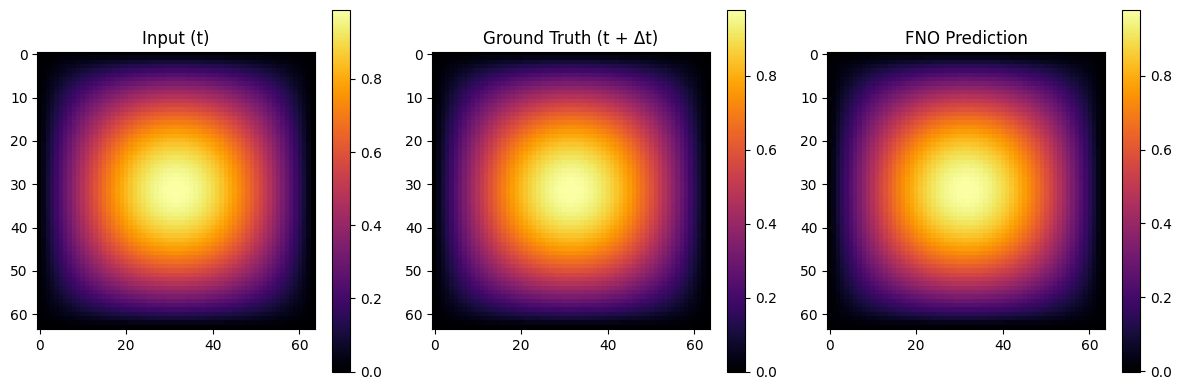

In [ ]:
import matplotlib.pyplot as plt

model.eval()
with torch.no_grad():
    idx = 10
    x_test = X[idx].unsqueeze(0).cuda()
    y_true = Y[idx].squeeze().cpu().numpy()
    y_pred = model(x_test).squeeze().cpu().numpy()

# Plot
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.title("Input (t)")
plt.imshow(X[idx][0], cmap='inferno')
plt.colorbar()

plt.subplot(1, 3, 2)
plt.title("Ground Truth (t + Δt)")
plt.imshow(y_true, cmap='inferno')
plt.colorbar()

plt.subplot(1, 3, 3)
plt.title("FNO Prediction")
plt.imshow(y_pred, cmap='inferno')
plt.colorbar()
plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import cm

# Use o resultado da simulação
u = generate_heat_2d_dataset()  # u.shape: (Nt, Nx, Ny)

fig, ax = plt.subplots()
cax = ax.imshow(u[0], cmap='inferno', origin='lower', vmin=np.min(u), vmax=np.max(u))
fig.colorbar(cax)
ax.set_title('Heat Equation Evolution')

def animate(i):
    cax.set_array(u[i])
    ax.set_title(f'Time step {i}')
    return [cax]

ani = animation.FuncAnimation(fig, animate, frames=len(u), interval=50, blit=True)

# Salvar como GIF
ani.save('heat_evolution.gif', writer='pillow', fps=20)

plt.close()

In [ ]:
y_pred

array([[ 0.000141  ,  0.00124603,  0.00249361, ...,  0.00258976,
         0.00059312, -0.00134232],
       [ 0.00108606,  0.00330909,  0.00613293, ...,  0.00606478,
         0.00266772, -0.00027492],
       [ 0.00242671,  0.00607193,  0.01098422, ...,  0.01089975,
         0.00551305,  0.00123597],
       ...,
       [ 0.00204478,  0.00655837,  0.01181036, ...,  0.01175205,
         0.00686121,  0.00295392],
       [ 0.00129331,  0.00424266,  0.00739153, ...,  0.00701521,
         0.00413171,  0.0016987 ],
       [ 0.00048003,  0.00227563,  0.00398314, ...,  0.00313906,
         0.00170174,  0.00044742]], dtype=float32)

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import cm
import torch

# Gerar os dados da solução real
u = generate_heat_2d_dataset()  # u.shape: (Nt, Nx, Ny)

# Avaliar a FNO
model.eval()
with torch.no_grad():
    idx = 10
    x_test = X[idx].unsqueeze(0).cuda()
    y_true = Y[idx].squeeze().cpu().numpy()
    y_pred = model(x_test).squeeze().cpu().numpy()

# Configuração para o gráfico
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Função de animação
def animate(i):
    # Limpar os eixos antes de atualizar
    ax[0].cla()
    ax[1].cla()

    # Solução real
    ax[0].imshow(u[i], cmap='inferno', origin='lower', vmin=np.min(u), vmax=np.max(u))
    ax[0].set_title(f"Real - Time step {i}")
    ax[0].set_xlabel('x')
    ax[0].set_ylabel('y')

    # Previsão da FNO
    ax[1].imshow(y_pred, cmap='inferno', origin='lower', vmin=np.min(u), vmax=np.max(u))
    ax[1].set_title(f"FNO Prediction - Time step {i}")
    ax[1].set_xlabel('x')
    ax[1].set_ylabel('y')

    return ax[0], ax[1]

# Criar animação
ani = animation.FuncAnimation(fig, animate, frames=len(u), interval=100, blit=False)

# Salvar como GIF
ani.save('real_vs_fno_evolution.gif', writer='pillow', fps=5)

plt.close()

In [ ]:
model.eval()
fno_predictions = []
input_fno = X[10].unsqueeze(0).cuda()  # ponto inicial

with torch.no_grad():
    for i in range(30):  # número de passos para simular
        pred = model(input_fno)
        fno_predictions.append(pred.squeeze().cpu().numpy())
        input_fno = pred  # usa a previsão como entrada do próximo passo

# Transforma lista em array (T, Nx, Ny)
fno_predictions = np.stack(fno_predictions)

# Pega a evolução real para os mesmos passos
u_real = u[11:41]  # se X[10] era t=10, então verdade começa em t=11 até t=40

# Plotar GIF lado a lado
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

def animate(i):
    ax[0].cla()
    ax[1].cla()

    ax[0].imshow(u_real[i], cmap='inferno', origin='lower', vmin=0, vmax=1)
    ax[0].set_title(f"Real - Time {i+11}")
    ax[0].set_xlabel('x')
    ax[0].set_ylabel('y')

    ax[1].imshow(fno_predictions[i], cmap='inferno', origin='lower', vmin=0, vmax=1)
    ax[1].set_title(f"FNO Prediction - Time {i+11}")
    ax[1].set_xlabel('x')
    ax[1].set_ylabel('y')

    return ax[0], ax[1]

ani = animation.FuncAnimation(fig, animate, frames=len(fno_predictions), interval=200, blit=False)
ani.save("fno_vs_real_autoregressive.gif", writer="pillow", fps=5)
plt.close()

In [1]:
import numpy as np

def generate_convection_diffusion_2d_sample(Nx=64, Ny=64, T=0.5, D=0.01, vx=1.0, vy=0.5):
    Lx, Ly = 1.0, 1.0
    dx, dy = Lx / (Nx - 1), Ly / (Ny - 1)
    dt = min(dx, dy)**2 / (4 * D + max(abs(vx), abs(vy))) * 0.5
    Nt = int(T / dt) + 1

    x = np.linspace(0, Lx, Nx)
    y = np.linspace(0, Ly, Ny)
    X, Y = np.meshgrid(x, y, indexing='ij')

    # Random pulse center
    cx, cy = np.random.uniform(0.3, 0.7), np.random.uniform(0.3, 0.7)
    sigma = 0.05
    u = np.zeros((Nt, Nx, Ny))
    u[0] = np.exp(-((X - cx)**2 + (Y - cy)**2) / (2 * sigma**2))

    for n in range(0, Nt - 1):
        un = u[n]
        u_next = np.copy(un)

        for i in range(1, Nx - 1):
            for j in range(1, Ny - 1):
                dudx = (un[i, j] - un[i - 1, j]) / dx
                dudy = (un[i, j] - un[i, j - 1]) / dy
                d2udx2 = (un[i + 1, j] - 2 * un[i, j] + un[i - 1, j]) / dx**2
                d2udy2 = (un[i, j + 1] - 2 * un[i, j] + un[i, j - 1]) / dy**2

                u_next[i, j] += dt * (
                    -vx * dudx - vy * dudy + D * (d2udx2 + d2udy2)
                )

        u_next[0, :] = u_next[-1, :] = u_next[:, 0] = u_next[:, -1] = 0
        u[n + 1] = u_next

    return u

def generate_dataset(num_samples=10):
    data = []
    for _ in range(num_samples):
        u = generate_convection_diffusion_2d_sample()
        data.append(u)
    return np.stack(data)

# Gerar e salvar o conjunto de dados menor
data = generate_dataset(num_samples=10)
np.save("convection_diffusion_dataset_small.npy", data)
data.shape

(10, 4128, 64, 64)

In [3]:
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset

# Carregar o dataset
data = np.load("convection_diffusion_dataset_small.npy")  # shape: (samples, Nt, Nx, Ny)
num_samples, Nt, Nx, Ny = data.shape

# Preparar pares (t, t + Δt)
X_list, Y_list = [], []
step = 5  # usar saltos de 5 steps para maior diversidade

for sample in range(num_samples):
    u = data[sample]
    for t in range(Nt - step):
        X_list.append(u[t])
        Y_list.append(u[t + step])

X = np.stack(X_list)  # shape: (N, Nx, Ny)
Y = np.stack(Y_list)

# Transformar em tensores
X_tensor = torch.tensor(X).unsqueeze(1).float()  # (N, 1, Nx, Ny)
Y_tensor = torch.tensor(Y).unsqueeze(1).float()

# DataLoader
dataset = TensorDataset(X_tensor, Y_tensor)
loader = DataLoader(dataset, batch_size=10, shuffle=True)


In [4]:
from neuralop.models import FNO
import torch.nn as nn
import torch.optim as optim

# Criar modelo
model = FNO(n_modes=(12, 12), hidden_channels=32, in_channels=1, out_channels=1).cuda()

# Otimizador e função de perda
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

epochs = 20
for epoch in range(epochs):
    model.train()
    epoch_loss = 0.0
    for xb, yb in loader:
        xb, yb = xb.cuda(), yb.cuda()
        optimizer.zero_grad()
        pred = model(xb)
        loss = loss_fn(pred, yb)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs} - Loss: {epoch_loss/len(loader):.6f}")


Epoch 1/20 - Loss: 0.000027
Epoch 2/20 - Loss: 0.000001
Epoch 3/20 - Loss: 0.000000
Epoch 4/20 - Loss: 0.000000
Epoch 5/20 - Loss: 0.000000
Epoch 6/20 - Loss: 0.000000
Epoch 7/20 - Loss: 0.000000
Epoch 8/20 - Loss: 0.000000
Epoch 9/20 - Loss: 0.000000
Epoch 10/20 - Loss: 0.000000
Epoch 11/20 - Loss: 0.000000
Epoch 12/20 - Loss: 0.000000
Epoch 13/20 - Loss: 0.000000
Epoch 14/20 - Loss: 0.000000
Epoch 15/20 - Loss: 0.000000
Epoch 16/20 - Loss: 0.000000
Epoch 17/20 - Loss: 0.000000
Epoch 18/20 - Loss: 0.000000
Epoch 19/20 - Loss: 0.000000
Epoch 20/20 - Loss: 0.000000


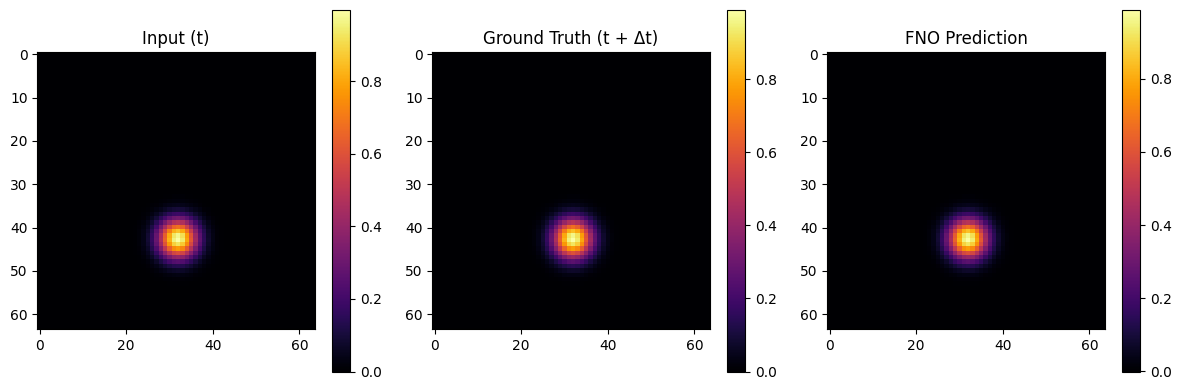

In [5]:
import matplotlib.pyplot as plt

model.eval()
with torch.no_grad():
    idx = 0
    x_in = X_tensor[idx].unsqueeze(0).cuda()
    y_true = Y_tensor[idx].squeeze().cpu().numpy()
    y_pred = model(x_in).squeeze().cpu().numpy()

# Plotar
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.title("Input (t)")
plt.imshow(X_tensor[idx][0], cmap='inferno')
plt.colorbar()

plt.subplot(1, 3, 2)
plt.title("Ground Truth (t + Δt)")
plt.imshow(y_true, cmap='inferno')
plt.colorbar()

plt.subplot(1, 3, 3)
plt.title("FNO Prediction")
plt.imshow(y_pred, cmap='inferno')
plt.colorbar()
plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import torch
import numpy as np

# Seleciona uma amostra do conjunto
sample_idx = 0
u_sample = data[sample_idx]  # shape (Nt, Nx, Ny)
Nt = u_sample.shape[0]

# Previsão FNO frame a frame (autoregressiva)
model.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
u_pred = [torch.tensor(u_sample[0]).unsqueeze(0).unsqueeze(0).to(device).float()]  # (1, 1, Nx, Ny)

with torch.no_grad():
    for t in range(1, Nt):
        next_pred = model(u_pred[-1])
        u_pred.append(next_pred)

# Converte para numpy
u_pred_np = [u.squeeze().cpu().numpy() for u in u_pred]

# Criação do GIF com matplotlib
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
ax_real, ax_pred = axs
img_real = ax_real.imshow(u_sample[0], cmap='inferno', vmin=0, vmax=1)
img_pred = ax_pred.imshow(u_pred_np[0], cmap='inferno', vmin=0, vmax=1)
ax_real.set_title("Solução Real")
ax_pred.set_title("Previsão FNO")
plt.tight_layout()

def update(t):
    img_real.set_data(u_sample[t])
    img_pred.set_data(u_pred_np[t])
    ax_real.set_xlabel(f"t = {t}")
    ax_pred.set_xlabel(f"t = {t}")
    return img_real, img_pred

ani = animation.FuncAnimation(fig, update, frames=Nt, interval=100, blit=False)

# Salvar como GIF
ani.save("evolucao_fno_vs_real.gif", writer="pillow")
plt.close()

print("GIF salvo como 'evolucao_fno_vs_real.gif'")


In [1]:
pip install -U neuraloperator

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 28.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 186.9/186.9 kB 19.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.7/117.7 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 122.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.3/59.3 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.9/203.9 kB 20.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 129.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 739.1/739.1 kB 57.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 107.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 95.5 MB/s e

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from neuralop.models import FNO
import numpy as np
import matplotlib.pyplot as plt

# 1️⃣ Gerar múltiplos casos via MDF
def generate_advection_diffusion(Nx=64, Ny=64, Nt=50, L=1.0, T=1.0, v_x=1.0, v_y=0.5, D=0.01, x0=0.5, y0=0.5):
    dx = L / (Nx - 1)
    dy = L / (Ny - 1)
    dt = 0.001
    x = np.linspace(0, L, Nx)
    y = np.linspace(0, L, Ny)
    X, Y = np.meshgrid(x, y, indexing='ij')

    c = np.zeros((Nt, Nx, Ny))
    c[0] = np.exp(-100 * ((X - x0)**2 + (Y - y0)**2))

    for n in range(0, Nt - 1):
        for i in range(1, Nx - 1):
            for j in range(1, Ny - 1):
                adv_x = -v_x * (c[n, i, j] - c[n, i - 1, j]) / dx
                adv_y = -v_y * (c[n, i, j] - c[n, i, j - 1]) / dy
                diff_x = D * (c[n, i + 1, j] - 2 * c[n, i, j] + c[n, i - 1, j]) / dx ** 2
                diff_y = D * (c[n, i, j + 1] - 2 * c[n, i, j] + c[n, i, j - 1]) / dy ** 2
                c[n + 1, i, j] = c[n, i, j] + dt * (adv_x + adv_y + diff_x + diff_y)
    return c

num_cases = 10
c_data_list = []
for _ in range(num_cases):
    x0 = np.random.uniform(0.3, 0.7)
    y0 = np.random.uniform(0.3, 0.7)
    c_data_list.append(generate_advection_diffusion(x0=x0, y0=y0))

c_data = np.stack(c_data_list)  # Shape: (num_cases, Nt, Nx, Ny)

# 2️⃣ Preparar dados (previsão 1 step)
X_train = torch.tensor(c_data[:, :-1]).unsqueeze(2).float()  # (num_cases, Nt-1, 1, Nx, Ny)
Y_train = torch.tensor(c_data[:, 1:]).unsqueeze(2).float()   # (num_cases, Nt-1, 1, Nx, Ny)

# Unir batch e tempo
X_train_flat = X_train.reshape(-1, 1, 64, 64)  # (num_cases*(Nt-1), 1, Nx, Ny)
Y_train_flat = Y_train.reshape(-1, 1, 64, 64)

print(f"X_train_flat shape: {X_train_flat.shape}")

# 3️⃣ Definir modelo FNO
model = FNO(n_modes=(12,12), hidden_channels=32, in_channels=1, out_channels=1)

# 4️⃣ Função de perda física
def physics_loss(pred, input_tensor, v_x=1.0, v_y=0.5, D=0.01, dx=1/63, dy=1/63, dt=0.001):
    dc_dt = (pred - input_tensor) / dt
    dc_dx = (pred - torch.roll(pred, 1, dims=2)) / dx
    dc_dy = (pred - torch.roll(pred, 1, dims=3)) / dy
    d2c_dx2 = (torch.roll(pred, -1, dims=2) - 2*pred + torch.roll(pred, 1, dims=2)) / dx**2
    d2c_dy2 = (torch.roll(pred, -1, dims=3) - 2*pred + torch.roll(pred, 1, dims=3)) / dy**2
    res = dc_dt + v_x * dc_dx + v_y * dc_dy - D * (d2c_dx2 + d2c_dy2)
    return torch.mean(res**2)

loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 5️⃣ Treinamento
for epoch in range(100):
    model.train()
    optimizer.zero_grad()
    output = model(X_train_flat)

    loss_data = loss_fn(output, Y_train_flat)
    loss_pde = physics_loss(output, X_train_flat)
    loss = loss_data + 1.0 * loss_pde

    loss.backward()
    optimizer.step()

    print(f"Epoch {epoch+1}: Loss_data={loss_data.item():.6f}, Loss_pde={loss_pde.item():.6f}")

# 6️⃣ Visualização de um caso
with torch.no_grad():
    idx = 0  # pegar o primeiro passo do primeiro caso
    pred = model(X_train_flat[idx:idx+1]).squeeze().cpu().numpy()
    real = Y_train_flat[idx].squeeze().cpu().numpy()

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.title("Ground Truth")
plt.imshow(real, cmap='viridis')
plt.colorbar()

plt.subplot(1,2,2)
plt.title("PINO Prediction")
plt.imshow(pred, cmap='viridis')
plt.colorbar()
plt.show()


X_train_flat shape: torch.Size([490, 1, 64, 64])
Epoch 1: Loss_data=0.012478, Loss_pde=12550.882812
Epoch 2: Loss_data=0.012579, Loss_pde=12652.037109
Epoch 3: Loss_data=0.012363, Loss_pde=12436.155273
Epoch 4: Loss_data=0.012266, Loss_pde=12338.477539
Epoch 5: Loss_data=0.012292, Loss_pde=12363.952148
Epoch 6: Loss_data=0.012220, Loss_pde=12291.287109
Epoch 7: Loss_data=0.012097, Loss_pde=12168.822266
Epoch 8: Loss_data=0.012026, Loss_pde=12097.537109
Epoch 9: Loss_data=0.011995, Loss_pde=12066.105469
Epoch 10: Loss_data=0.011931, Loss_pde=12001.077148
Epoch 11: Loss_data=0.011819, Loss_pde=11888.742188
Epoch 12: Loss_data=0.011702, Loss_pde=11771.229492
Epoch 13: Loss_data=0.011604, Loss_pde=11673.161133
Epoch 14: Loss_data=0.011499, Loss_pde=11567.395508
Epoch 15: Loss_data=0.011348, Loss_pde=11415.441406
Epoch 16: Loss_data=0.011150, Loss_pde=11216.743164
Epoch 17: Loss_data=0.010927, Loss_pde=10992.627930
Epoch 18: Loss_data=0.010679, Loss_pde=10742.751953
Epoch 19: Loss_data=0.01

KeyboardInterrupt: 

<ipython-input-5-1d738d860765>:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axes = plt.subplots(num_plot_cases, 3, figsize=(12, 4*num_plot_cases))


GIF salvo como 'comparacao_pino.gif'


<Figure size 640x480 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

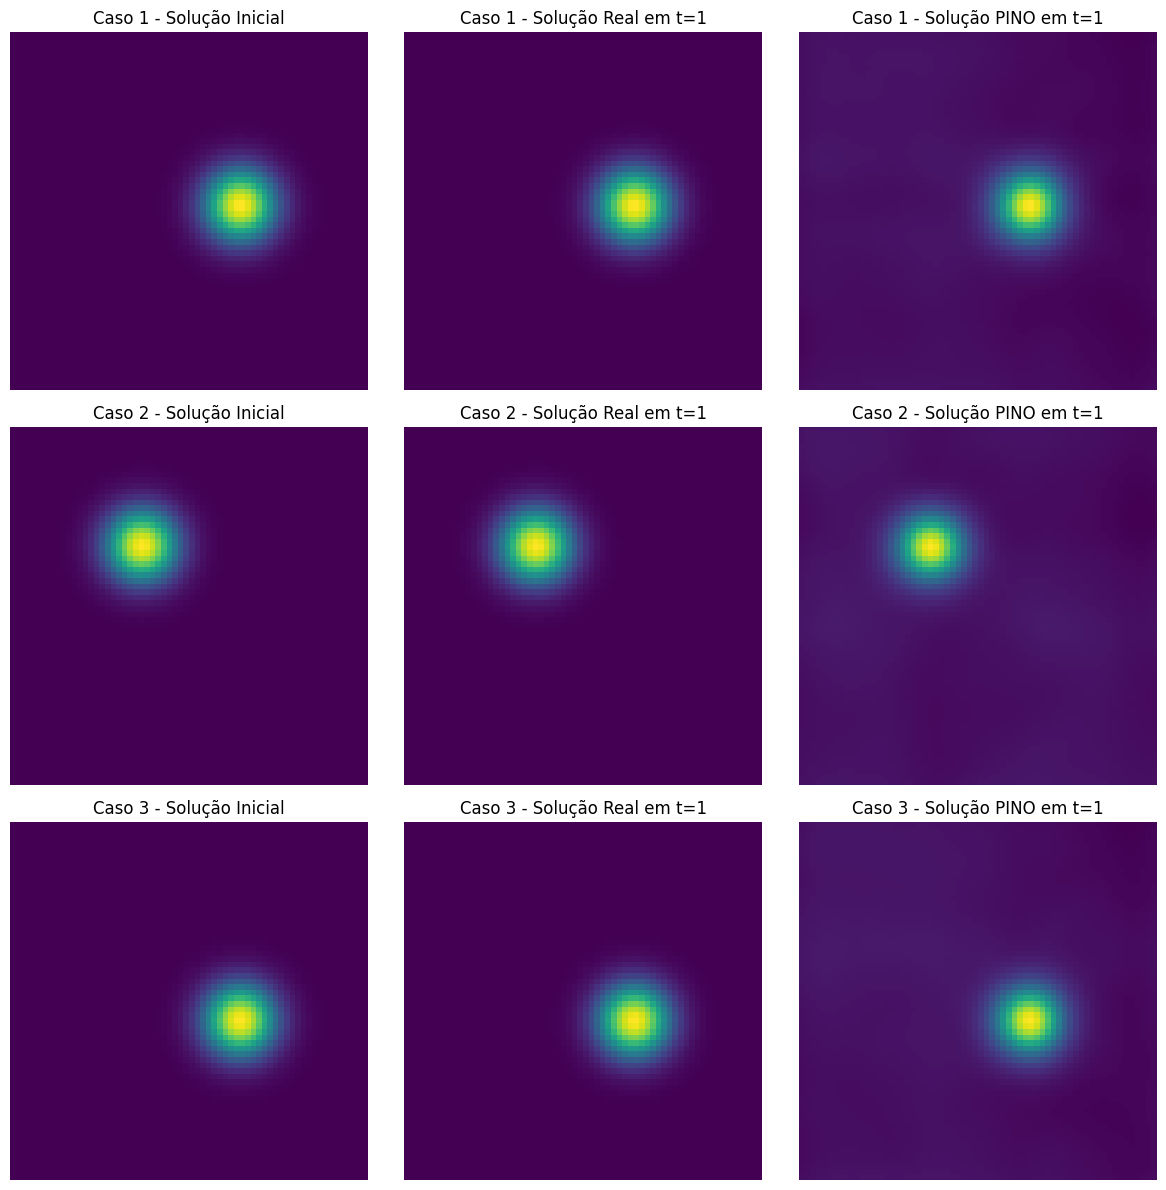

In [5]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# 1️⃣ Pegar 9 casos diferentes (ou menos se tiver menos)
num_plot_cases = min(3, num_cases)
steps = X_train.shape[1]  # número de passos de tempo (Nt-1)

# 2️⃣ Fazer predições de todos os passos para os 9 casos
pred_list = []
with torch.no_grad():
    for i in range(num_plot_cases):
        preds = []
        input_t = X_train[i,0:1]
        for t in range(steps):
            output_t = model(input_t.reshape(1,1,64,64))
            preds.append(output_t.squeeze(0).cpu().numpy())
            input_t = output_t  # usa predição como próxima entrada
        pred_list.append(np.stack(preds))  # (steps, 64, 64)

# 3️⃣ Função de plot para cada frame
def plot_frame(t_idx):
    fig, axes = plt.subplots(num_plot_cases, 3, figsize=(12, 4*num_plot_cases))
    for i in range(num_plot_cases):
        # dados reais
        real_init = X_train[i,0,0].cpu().numpy().squeeze()
        real_true = Y_train[i,t_idx,0].cpu().numpy().squeeze()
        pred = pred_list[i][t_idx].squeeze()

        axes[i,0].imshow(real_init, cmap='viridis')
        axes[i,0].set_title(f'Caso {i+1} - Solução Inicial')

        axes[i,1].imshow(real_true, cmap='viridis')
        axes[i,1].set_title(f'Caso {i+1} - Solução Real em t={t_idx+1}')

        axes[i,2].imshow(pred, cmap='viridis')
        axes[i,2].set_title(f'Caso {i+1} - Solução PINO em t={t_idx+1}')

        for j in range(3):
            axes[i,j].axis('off')
    plt.tight_layout()
    return fig

# 4️⃣ Criar animação
fig = plt.figure()

def animate(t_idx):
    plt.clf()
    return plot_frame(t_idx)

ani = animation.FuncAnimation(fig, animate, frames=steps, repeat=False)

# 5️⃣ Salvar como GIF
ani.save('comparacao_pino.gif', writer='pillow', fps=5)

print("GIF salvo como 'comparacao_pino.gif'")

<ipython-input-5-1d738d860765>:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axes = plt.subplots(num_plot_cases, 3, figsize=(12, 4*num_plot_cases))


<Figure size 640x480 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

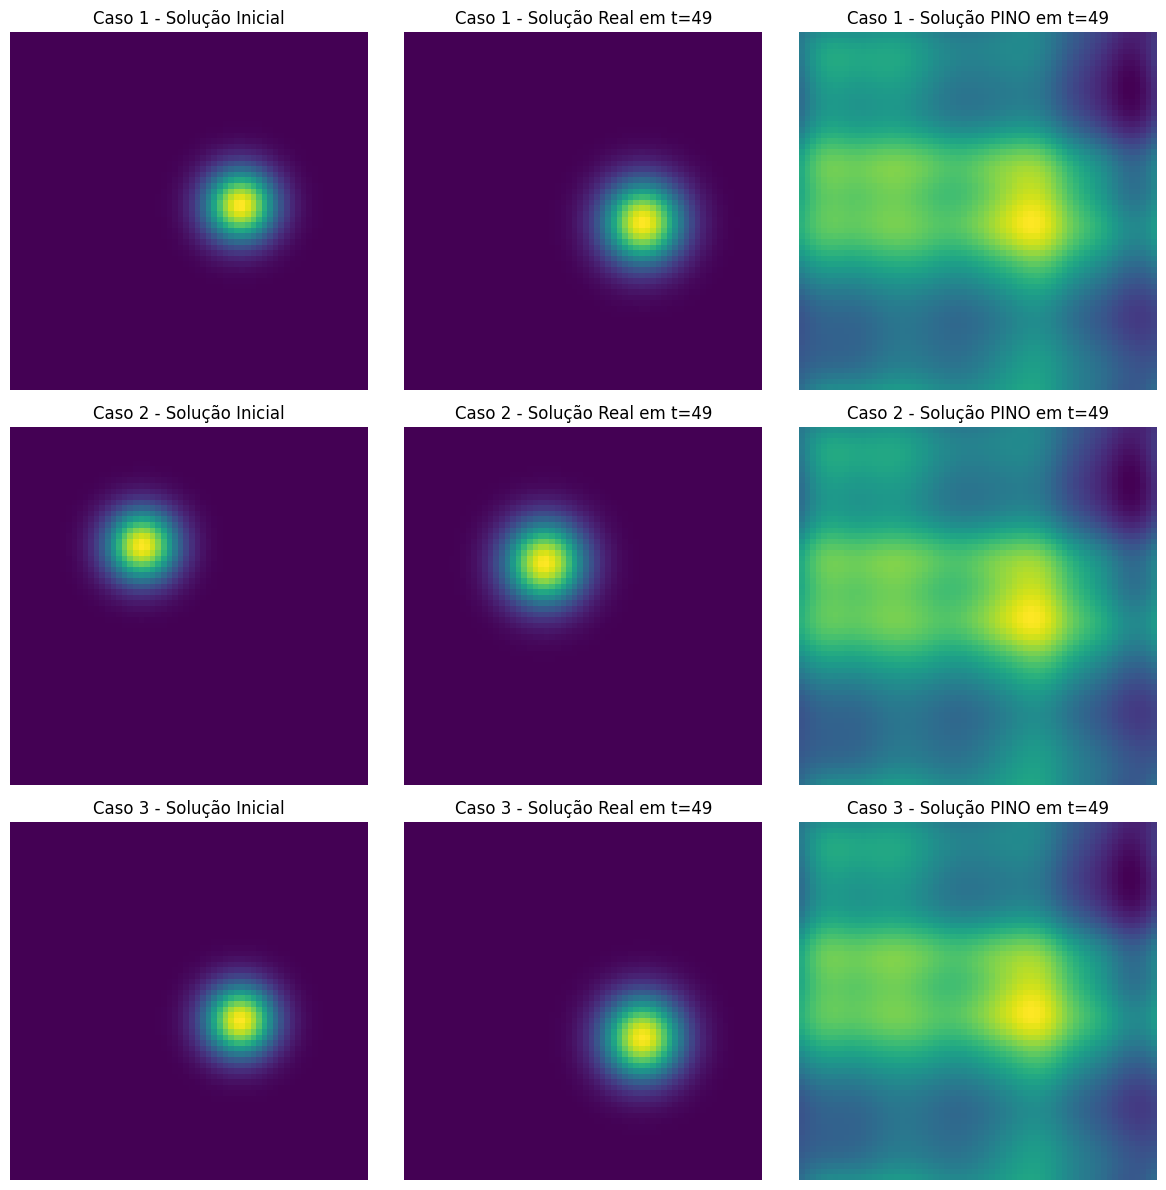

In [6]:
from IPython.display import HTML
HTML(ani.to_jshtml())